In [2]:
%pip install matplotlib numpy pandas scikit-learn seaborn opendatasets legacy-cgi 

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import opendatasets as od
od.download('https://www.kaggle.com/datasets/shankarpriya2913/crop-and-soil-dataset')
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

Skipping, found downloaded files in ".\crop-and-soil-dataset" (use force=True to force download)


In [4]:
df = pd.read_csv('crop-and-soil-dataset/data_core.csv')
eval_metrics = [['Model','MAE','MSE','RMSE','R2'],0,0,0,0]

In [24]:
#categorical columns
categorical_cols = ['Soil Type', 'Crop Type','Fertilizer Name']

from sklearn.preprocessing import LabelEncoder
encoders = {}
for col in categorical_cols:
    enc = LabelEncoder()
    df[col] = enc.fit_transform(df[col])
    encoders[col] = enc  # store encoder for later

print("Mappings for Soil Type:", list(encoders['Soil Type'].classes_))
print("Mappings for Crop Type:", list(encoders['Crop Type'].classes_))

print(df.head())


Mappings for Soil Type: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
Mappings for Crop Type: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)]
   Temparature  Humidity  Moisture  Soil Type  Crop Type  Nitrogen  Potassium  \
0         26.0      52.0      38.0          4          3        37          0   
1         29.0      52.0      45.0          2          8        12          0   
2         34.0      65.0      62.0          0          1         7          9   
3         32.0      62.0      34.0          3          9        22          0   
4         28.0      54.0      46.0          1          6        35          0   

   Phosphorous  Fertilizer Name  
0            0                6  
1           36                5  
2           30                1  
3           20                4  
4            0                6  


In [25]:
corr_matrix = df.corr(numeric_only = True)
print(corr_matrix)

                 Temparature  Humidity  Moisture  Soil Type  Crop Type  \
Temparature         1.000000  0.525594  0.067963   0.009544   0.006371   
Humidity            0.525594  1.000000  0.066713   0.005344   0.026676   
Moisture            0.067963  0.066713  1.000000   0.006529   0.000604   
Soil Type           0.009544  0.005344  0.006529   1.000000  -0.007889   
Crop Type           0.006371  0.026676  0.000604  -0.007889   1.000000   
Nitrogen           -0.028978 -0.042701 -0.085016   0.019426   0.005704   
Potassium          -0.031322  0.005695  0.023618  -0.018297  -0.014214   
Phosphorous         0.166951  0.136216  0.011854   0.004211   0.004033   
Fertilizer Name     0.002702 -0.008726  0.004051  -0.000002   0.010664   

                 Nitrogen  Potassium  Phosphorous  Fertilizer Name  
Temparature     -0.028978  -0.031322     0.166951         0.002702  
Humidity        -0.042701   0.005695     0.136216        -0.008726  
Moisture        -0.085016   0.023618     0.011854   

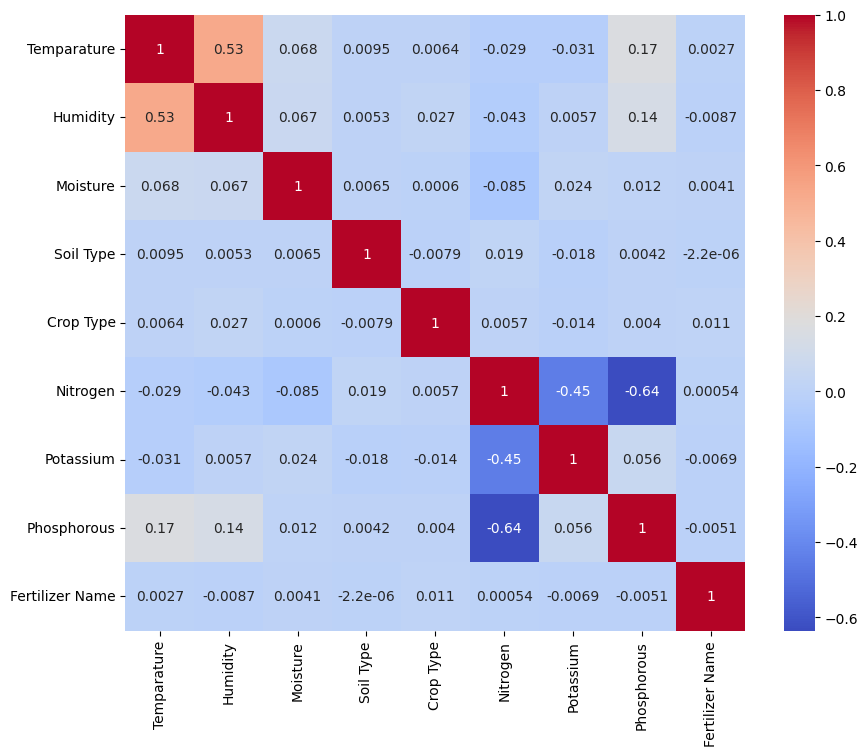

In [26]:
import seaborn as sns

corr_matrix = df.corr(numeric_only=True)  # or use numeric_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


In [27]:
print(df.columns.tolist())

['Temparature', 'Humidity', 'Moisture', 'Soil Type', 'Crop Type', 'Nitrogen', 'Potassium', 'Phosphorous', 'Fertilizer Name']


In [34]:
# import modified dataset
# split into features(x) and target(y)
X = df.drop('Moisture',axis=1)
Y = df['Moisture']

numerical_cols = ['Temparature', 'Humidity', 'Nitrogen', 'Potassium', 'Phosphorous']  # Removed 'Moisture'
categorical_cols = ['Soil Type', 'Crop Type', 'Fertilizer Name']

# split data in traiining and testing sets for x and y both
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.2,random_state=42)
print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape)

print("Features in X_train:", X_train.columns.tolist())

missing_num = [col for col in numerical_cols if col not in X_train.columns]
missing_cat = [col for col in categorical_cols if col not in X_train.columns]

if missing_num or missing_cat:
    print("Warning: The following columns are missing from X_train:")
    print("Numerical:", missing_num)
    print("Categorical:", missing_cat)
    print("Available columns:", X_train.columns.tolist())
    raise ValueError("Column mismatch detected")

(6400, 8) (1600, 8) (6400,) (1600,)
Features in X_train: ['Temparature', 'Humidity', 'Soil Type', 'Crop Type', 'Nitrogen', 'Potassium', 'Phosphorous', 'Fertilizer Name']


Mean Absolute Error : 10.25920152889858
Mean Squared Error : 157.61019142545408
Root Mean Squared Error : 12.554289761888327
R-squared : 0.00385392449313382


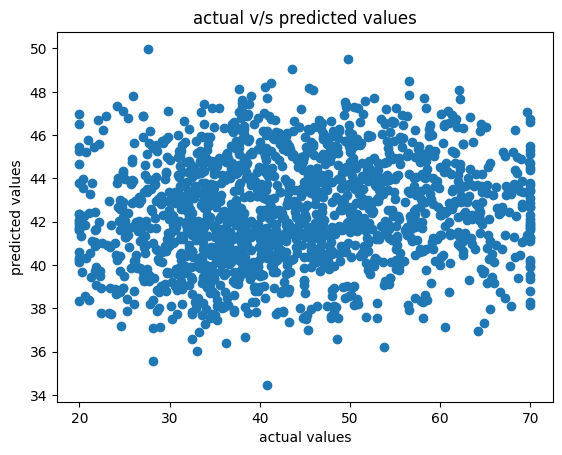

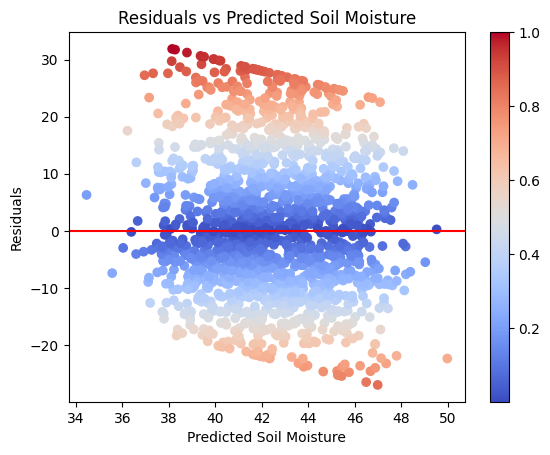

In [35]:
# support vector machine
# fit() do not accept strings --> to handle mixed data types
#pipeline + col. transformer + oneHotEncoder

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR

preprocessor = ColumnTransformer(
    transformers=[
        ('num',StandardScaler(),numerical_cols),
        ('cat',OneHotEncoder(handle_unknown='ignore'),categorical_cols)
    ]
)
svm = SVR(kernel = 'linear')

pipeline = Pipeline([
    ('preprocessor',preprocessor),
    ('regressor',svm)
])


pipeline.fit(X_train,Y_train)

Y_pred = pipeline.predict(X_test)

mae = mean_absolute_error(Y_test,Y_pred)
mse = mean_squared_error(Y_test,Y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(Y_test,Y_pred)

# evaluation metrics
print('Mean Absolute Error :',mae)
print('Mean Squared Error :',mse)
print('Root Mean Squared Error :',rmse)
print('R-squared :',r2)

err = ["Support Vector Mechanism",mae,mse,rmse,r2]
eval_metrics[1] = err

plt.scatter(Y_test.values,Y_pred)
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.title('actual v/s predicted values')
plt.show()

# residuals plotted now
residuals = Y_test.values - Y_pred
cmap = plt.cm.coolwarm
norm = plt.Normalize(vmin=0, vmax=np.abs(residuals).max())
plt.scatter(Y_pred, residuals, c=norm(np.abs(residuals)), cmap=cmap)
plt.xlabel('Predicted Soil Moisture')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Soil Moisture')
plt.axhline(y=0, color='r', linestyle='-') #horizontal line at y=0
plt.colorbar() #colorbar to show shading scale
plt.show()

In [ ]:
 # gradient boosting regression
